In [56]:
import arviz as az
import bambi as bmb
import pandas as pd
import pymc as pm
from scipy.special import expit

In [6]:
df = (bmb
     .load_data("batting")
     .query('yearID == 2018')
     )
     
df.head()

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
104325,abreujo02,2018,1,CHA,AL,128,499,68,132,36,...,78.0,2.0,0.0,37,109.0,7.0,11.0,0.0,6.0,14.0
104326,acunaro01,2018,1,ATL,NL,111,433,78,127,26,...,64.0,16.0,5.0,45,123.0,2.0,6.0,0.0,3.0,4.0
104327,adamewi01,2018,1,TBA,AL,85,288,43,80,7,...,34.0,6.0,5.0,31,95.0,3.0,1.0,1.0,2.0,6.0
104328,adamja01,2018,1,KCA,AL,31,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
104329,adamsau02,2018,1,WAS,NL,2,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0


# LOGIT-BINOMIAL MODEL

In [3]:
model_logit_binomial = (bmb
                        .Model("p(H, AB) ~ 1 + (1|teamID)",  
                        data=df, 
                        family="binomial")
                        )

model_logit_binomial

Formula: p(H, AB) ~ 1 + (1|teamID)
Family name: Binomial
Link: logit
Observations: 1535
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 2.5)

  Group-level effects
    1|teamID ~ Normal(mu: 0, sigma: HalfNormal(sigma: 2.5))

In [82]:
idata_logit_binomial = model_logit_binomial.fit(draws=5_000, tune=3_000)

idata_logit_binomial

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, 1|teamID_sigma, 1|teamID_offset]
INFO:pymc:NUTS: [Intercept, 1|teamID_sigma, 1|teamID_offset]


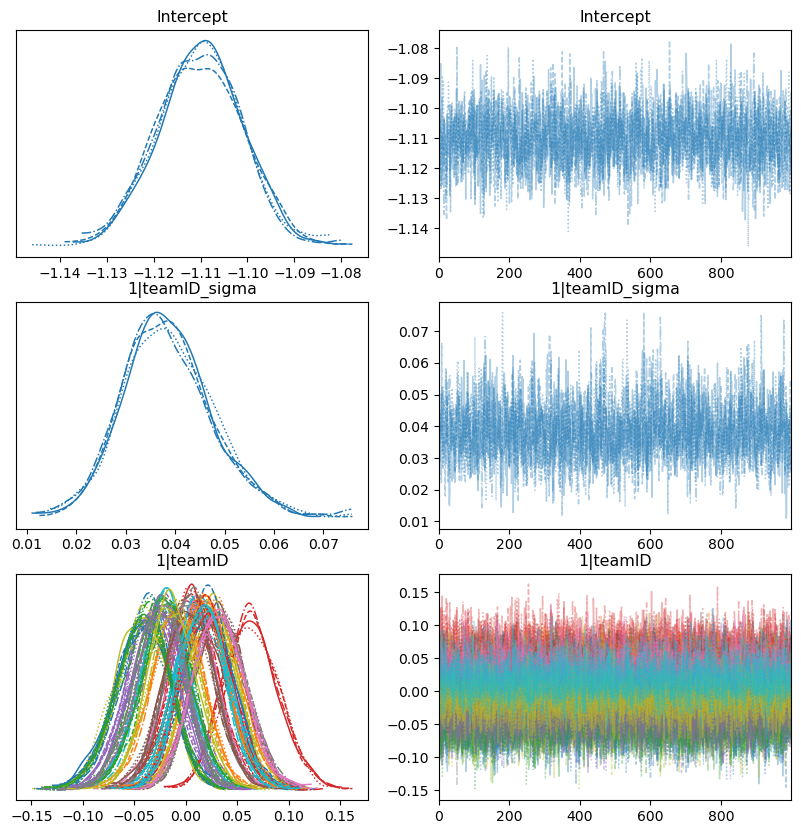

In [47]:
az.plot_trace(idata_logit_binomial, compact=True, figsize=(10,10));

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

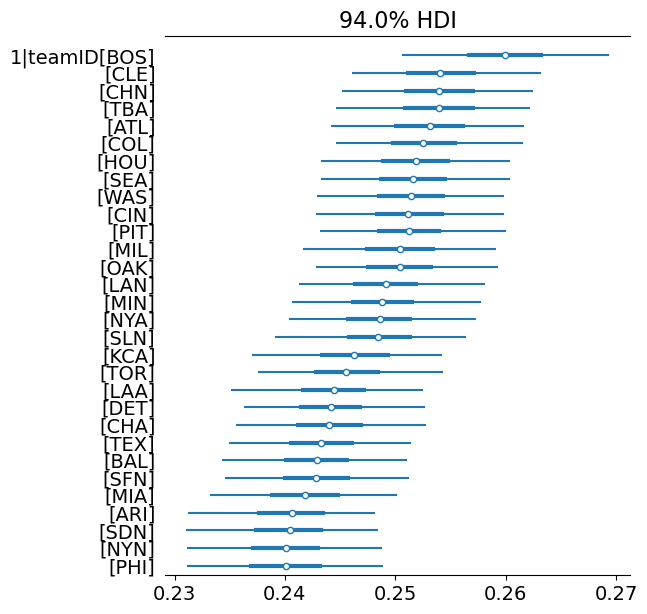

In [63]:
logit_binomial_theta_post_means = idata_logit_binomial.posterior['1|teamID'].mean(dim=("chain", "draw"))
idata_logit_binomial.posterior = idata_logit_binomial.posterior.sortby(logit_binomial_theta_post_means, ascending=False)

az.plot_forest(idata_logit_binomial, var_names=['1|teamID'], combined=True, transform = lambda x: expit(idata_logit_binomial.posterior.Intercept + x))

# BETA-BINOMIAL MODEL

In [78]:
priors = {
    "Intercept": bmb.Prior("Beta", alpha=2, beta=10),
    "1|teamID": bmb.Prior("Beta", alpha=1, beta=10)
}

model_beta_binomial = (bmb
                        .Model("p(H, AB) ~ 1 + (1|teamID))",  
                        data=df, 
                        family="binomial",
                        priors=priors, # add the beta prior
                        link='identity' # change the link to identity (conjugacy gives us a beta posterior)
                        )
                        )

model_beta_binomial

Formula: p(H, AB) ~ 1 + (1|teamID))
Family name: Binomial
Link: identity
Observations: 1535
Priors:
  Common-level effects
    Intercept ~ Beta(alpha: 2, beta: 10)

  Group-level effects
    1|teamID ~ Beta(alpha: 1, beta: 10)

In [79]:
idata_beta_binomial = model_beta_binomial.fit(draws=5_000, tune=3_000)

idata_beta_binomial

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, 1|teamID]
INFO:pymc:NUTS: [Intercept, 1|teamID]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

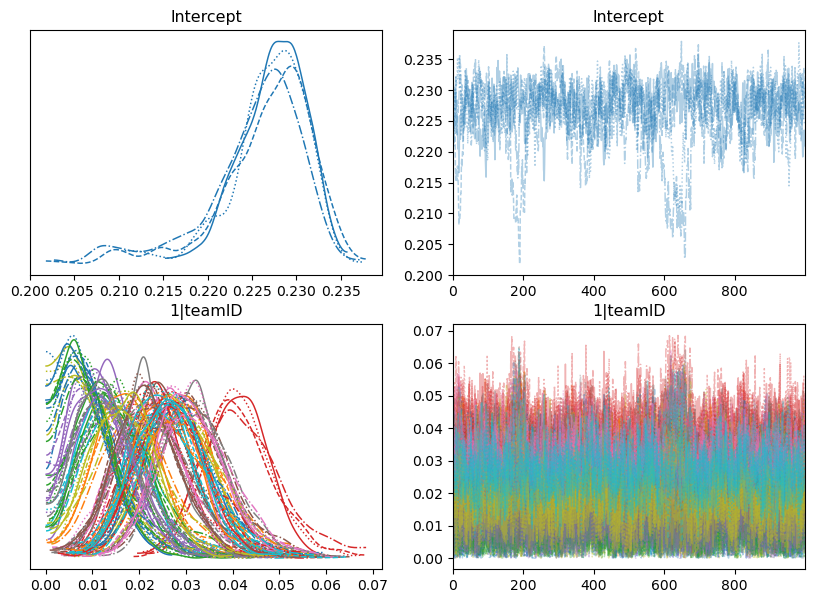

In [80]:
az.plot_trace(idata_beta_binomial, figsize=(10,7));

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

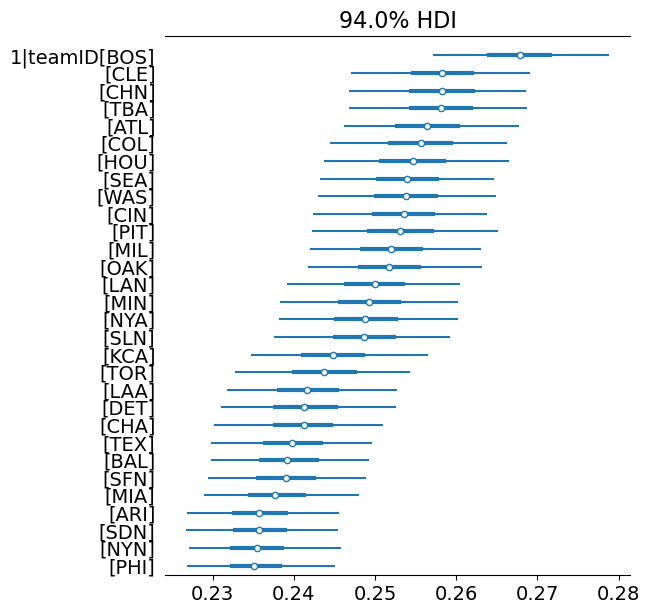

In [81]:
logit_beta_theta_post_means = idata_beta_binomial.posterior['1|teamID'].mean(dim=("chain", "draw"))
idata_beta_binomial.posterior = idata_beta_binomial.posterior.sortby(logit_beta_theta_post_means, ascending=False)

az.plot_forest(idata_beta_binomial, var_names=['1|teamID'], combined=True, transform=lambda x: idata_beta_binomial.posterior.Intercept + x)